In [325]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import time
#-----------------------------------------------------------
# 1. Create the initial system configuration.
#-----------------------------------------------------------
@njit
def polymergenerator(polymerl, headl):
    # Use a NumPy array for the center-of-mass (COM)
    COM = np.array([5.0, 2.5, 0.60])
    # Create a linear polymer (each row is a 3D coordinate)
    polymer = np.empty((polymerl, 3))
    for i in range(polymerl):
        polymer[i, 0] = float(i)
        polymer[i, 1] = 0.0
        polymer[i, 2] = 0.0
    # Shift the polymer to create a surface
    polymersurface = np.empty((polymerl, 3))
    for i in range(polymerl):
        polymersurface[i, 0] = polymer[i, 0]
        polymersurface[i, 1] = polymer[i, 1] + 0.5
        polymersurface[i, 2] = polymer[i, 2]
    # Create a head surface (with 4 atoms surrounding COM)
    headsurface = np.empty((4, 3))
    for i in range(4):
        headsurface[i, 0] = COM[0]
        headsurface[i, 1] = COM[1]
        headsurface[i, 2] = COM[2]
    # Add small offsets
    offsets = np.array([[0.1, 0.0, 0.0],
                        [0.0, 0.1, 0.0],
                        [-0.1, 0.0, 0.0],
                        [0.0, -0.1, 0.0]])
    for i in range(4):
        headsurface[i, 0] += offsets[i, 0]
        headsurface[i, 1] += offsets[i, 1]
        headsurface[i, 2] += offsets[i, 2]
    return polymer, polymersurface, COM, headsurface

#-----------------------------------------------------------
# 2. Define force‐calculation functions.
#-----------------------------------------------------------
@njit
def lj_brownian(a, b, epsilon=0.1, sigma=2.0):
    """
    Computes a Lennard-Jones-type force between each point in array a and the single point b.
    """
    N = a.shape[0]
    f_total0 = 0.0
    f_total1 = 0.0
    f_total2 = 0.0
    for i in range(N):
        dif0 = a[i, 0] - b[0]
        dif1 = a[i, 1] - b[1]
        dif2 = a[i, 2] - b[2]
        dist = np.sqrt(dif0*dif0 + dif1*dif1 + dif2*dif2)
        if dist == 0:
            continue
        f_val = 24 * epsilon * (-2*(sigma**12 / (dist**13)) + (sigma**6 / (dist**7)))
        inv_dist = 1.0 / dist
        f_total0 += f_val * dif0 * inv_dist
        f_total1 += f_val * dif1 * inv_dist
        f_total2 += f_val * dif2 * inv_dist
    res = np.empty(3)
    res[0] = f_total0
    res[1] = f_total1
    res[2] = f_total2
    return res

@njit
def harmonic_angle(surface, COM, n, theta=np.pi/2, K=10.0):
    """
    Compute the harmonic-angle force for each atom in the surface.
    The np.roll operation is implemented manually.
    """
    N = surface.shape[0]
    ab = np.empty((N, 3))
    bc = np.empty((N, 3))
    for i in range(N):
        # vector from COM to atom i
        ab[i, 0] = surface[i, 0] - COM[0]
        ab[i, 1] = surface[i, 1] - COM[1]
        ab[i, 2] = surface[i, 2] - COM[2]
        # rolled vector: (i+n) mod N
        j = (i + n) % N
        bc[i, 0] = surface[j, 0] - COM[0]
        bc[i, 1] = surface[j, 1] - COM[1]
        bc[i, 2] = surface[j, 2] - COM[2]
    ab_norm = np.empty(N)
    bc_norm = np.empty(N)
    for i in range(N):
        ab_norm[i] = np.sqrt(ab[i, 0]**2 + ab[i, 1]**2 + ab[i, 2]**2)
        bc_norm[i] = np.sqrt(bc[i, 0]**2 + bc[i, 1]**2 + bc[i, 2]**2)
    cos_angle = np.empty(N)
    for i in range(N):
        cos_angle[i] = (ab[i, 0]*bc[i, 0] + ab[i, 1]*bc[i, 1] + ab[i, 2]*bc[i, 2]) / (ab_norm[i]*bc_norm[i] + 1e-12)
        if cos_angle[i] > 1.0:
            cos_angle[i] = 1.0
        elif cos_angle[i] < -1.0:
            cos_angle[i] = -1.0
    angle_diff = np.empty(N)
    for i in range(N):
        angle_diff[i] = theta - np.arccos(cos_angle[i])
    cross_inner = np.empty((N, 3))
    for i in range(N):
        cross_inner[i, 0] = bc[i, 1]*ab[i, 2] - bc[i, 2]*ab[i, 1]
        cross_inner[i, 1] = bc[i, 2]*ab[i, 0] - bc[i, 0]*ab[i, 2]
        cross_inner[i, 2] = bc[i, 0]*ab[i, 1] - bc[i, 1]*ab[i, 0]
    vector = np.empty((N, 3))
    for i in range(N):
        vector[i, 0] = ab[i, 1]*cross_inner[i, 2] - ab[i, 2]*cross_inner[i, 1]
        vector[i, 1] = ab[i, 2]*cross_inner[i, 0] - ab[i, 0]*cross_inner[i, 2]
        vector[i, 2] = ab[i, 0]*cross_inner[i, 1] - ab[i, 1]*cross_inner[i, 0]
    vec_norm = np.empty(N)
    for i in range(N):
        vec_norm[i] = np.sqrt(vector[i, 0]**2 + vector[i, 1]**2 + vector[i, 2]**2)
    force = np.empty((N, 3))
    for i in range(N):
        if vec_norm[i] != 0:
            force[i, 0] = -2 * K * angle_diff[i] * vector[i, 0] / vec_norm[i]
            force[i, 1] = -2 * K * angle_diff[i] * vector[i, 1] / vec_norm[i]
            force[i, 2] = -2 * K * angle_diff[i] * vector[i, 2] / vec_norm[i]
        else:
            force[i, 0] = 0.0
            force[i, 1] = 0.0
            force[i, 2] = 0.0
    return force

@njit
def harmonic_surface(surface, COM, epsilon=10.0, sigma=0.1):
    """
    Compute a harmonic bond force for the surface atoms relative to COM.
    """
    N = surface.shape[0]
    force = np.empty((N, 3))
    for i in range(N):
        dx = surface[i, 0] - COM[0]
        dy = surface[i, 1] - COM[1]
        dz = surface[i, 2] - COM[2]
        norm_val = np.sqrt(dx*dx + dy*dy + dz*dz)
        if norm_val == 0:
            force[i, 0] = 0.0
            force[i, 1] = 0.0
            force[i, 2] = 0.0
        else:
            factor = 2 * epsilon * (sigma - norm_val) / norm_val
            force[i, 0] = factor * dx
            force[i, 1] = factor * dy
            force[i, 2] = factor * dz
    return force

#-----------------------------------------------------------
# 3. Define the integration function (Not-Verlet algorithm)
#-----------------------------------------------------------
@njit
def notverlet(COM, surface, dt, random_val, mu, polymer, polymersurface):
    # Generate a random force vector for this time step.
    # Sum contributions from the harmonic angle forces.
    force1 = harmonic_angle(surface, COM, 1)
    force2 = harmonic_angle(surface, COM, -1)
    force3 = harmonic_angle(surface, COM, 2, np.pi)
    angle_forces = np.empty((4, 3))
    for i in range(4):
        angle_forces[i, 0] = force1[i, 0] + force2[i, 0] + force3[i, 0]
        angle_forces[i, 1] = force1[i, 1] + force2[i, 1] + force3[i, 1]
        angle_forces[i, 2] = force1[i, 2] + force2[i, 2] + force3[i, 2]
    # Get the harmonic bond force.
    harmonic_bond = harmonic_surface(surface, COM)
    # Calculate the Lennard-Jones (Brownian) force on a particular surface atom.
    lj_force_surf = np.zeros_like(surface,dtype=np.float64)
    """for i in range(4):
        if i == 3: lj_force_surf[i] = lj_brownian(polymersurface, surface[3], 10, 0.5)
        else: lj_force_surf[i] = [0,0,0]"""
    
    lj_force_surf[3] = lj_brownian(polymersurface, surface[3], 1.0, 0.5)
    # Update the surface positions.
    new_surface = np.empty_like(surface)
    # Compute the force on the COM from the polymer.
    lj_force_COM = lj_brownian(polymer, COM, 0.1, 1.2)
    sum_hb0 = 0.0
    sum_hb1 = 0.0
    sum_hb2 = 0.0
    for i in range(harmonic_bond.shape[0]):
        sum_hb0 += harmonic_bond[i, 0]
        sum_hb1 += harmonic_bond[i, 1]
        sum_hb2 += harmonic_bond[i, 2]
    for i in range(4):
        new_surface[i, 0] = surface[i, 0] + dt * (mu * (angle_forces[i, 0] + harmonic_bond[i, 0] + lj_force_surf[i,0]) + 0.01*np.random.uniform(-random_val, random_val))
        new_surface[i, 1] = surface[i, 1] + dt * (mu * (angle_forces[i, 1] + harmonic_bond[i, 1] + lj_force_surf[i,1]) + 0.01*np.random.uniform(-random_val, random_val))
        new_surface[i, 2] = surface[i, 2] + dt * (mu * (angle_forces[i, 2] + harmonic_bond[i, 2] + lj_force_surf[i,2]) + 0.01*np.random.uniform(-random_val, random_val))
    new_COM = np.empty(3)
    new_COM[0] = COM[0] + dt * (mu * (lj_force_COM[0] - sum_hb0) + np.random.uniform(-random_val, random_val))
    new_COM[1] = COM[1] + dt * (mu * (lj_force_COM[1] - sum_hb1) + np.random.uniform(-random_val, random_val))
    new_COM[2] = COM[2] + dt * (mu * (lj_force_COM[2] - sum_hb2) + np.random.uniform(-random_val, random_val))
    return new_COM, new_surface

#-----------------------------------------------------------
# 4. Define the simulation loop.
#    Progress messages are printed every 'print_every' steps.
#-----------------------------------------------------------
@njit
def simulate(COM, surface, polymer, polymersurface, steps, dt, random_val, mu, print_every):
    headhist = np.empty((steps, 3))
    surfacehist = np.empty((steps, surface.shape[0], 3))
    headhist[0] = COM
    surfacehist[0] = surface
    for i in range(1, steps):
        COM, surface = notverlet(COM, surface, dt, random_val, mu, polymer, polymersurface)
        headhist[i] = COM
        surfacehist[i] = surface
        if i % print_every == 0:
            # Note: print in njit functions is allowed in nopython mode.
            print("Step", i, "/", steps, "COM:",
                  COM[0], COM[1], COM[2])
    return headhist, surfacehist

In [326]:

#-----------------------------------------------------------
# 5. Main simulation parameters and execution.
#-----------------------------------------------------------
polymerLength = 10
headN = 1
steps = 2000000
dt = 0.01
random_val = 0.1
mu = 1.0
print_every = 100000

# Initialize the system.
polymer, polymersurface, COM, surface = polymergenerator(polymerLength, headN)

# Run the simulation (the entire simulation loop is compiled for speed).
start = time.perf_counter()
headhist, surfacehist = simulate(COM, surface, polymer, polymersurface, steps, dt, random_val, mu, print_every)
print("Simulation complete. Final COM:", headhist[steps - 1])
end = time.perf_counter()
print("Elapsed (after compilation) = {}s".format((end - start)))

Step 100000 / 2000000 COM: 4.496922939391917 -1.2052840264831721 0.29690550313141617
Step 200000 / 2000000 COM: 4.485961102617031 -1.2391460695128966 0.1332699024059352
Step 300000 / 2000000 COM: 4.506261526908687 -1.236873861575378 0.09688411186104735
Step 400000 / 2000000 COM: 4.510235266727003 -1.242203184676817 0.015587183096401041
Step 500000 / 2000000 COM: 4.506148959613959 -1.2360538834272445 -0.062002694754582546
Step 600000 / 2000000 COM: 4.502825460940483 -1.2400525373526503 0.02530338900530104
Step 700000 / 2000000 COM: 4.498218580487905 -1.2370314486430878 -0.0017185107496651693
Step 800000 / 2000000 COM: 4.4989482785760755 -1.2332552226554314 0.1391973090361979
Step 900000 / 2000000 COM: 4.474032385551693 -1.2469565724576641 0.01510641030950462
Step 1000000 / 2000000 COM: 4.4945432703248125 -1.2429270989100663 0.005613368390549356
Step 1100000 / 2000000 COM: 4.494985386319643 -1.2409856822072178 0.07375658108646965
Step 1200000 / 2000000 COM: 4.500103917725989 -1.238287685

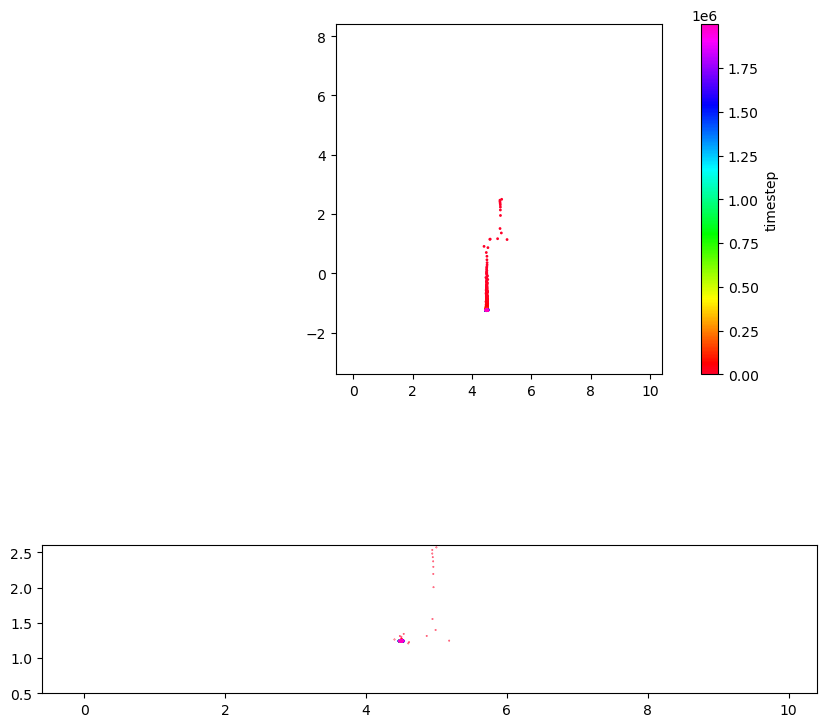

In [327]:
# (This cell uses your original plotting tools.)
render_everyN = 200
orthogonal_distance = np.linalg.norm(headhist[::render_everyN, 1:3], axis=1)
time_arr = np.arange(steps)



#fig, ax = plt.subplots(2, gridspec_kw={'height_ratios': [4, 4]}, figsize=(10, 10))
fig, ax = plt.subplots(2, figsize=(10, 10))
pos = ax[0].scatter(headhist[::render_everyN, 0], headhist[::render_everyN, 1], cmap="gist_rainbow", c=time_arr[::render_everyN], s=1)
ax[0].set_xlim(-0.6, 10.4)
ax[0].set_ylim(-3.4, 8.4)
ax[0].set_aspect("equal", adjustable="box")
perp = ax[1].scatter(headhist[::render_everyN, 0], orthogonal_distance[::], cmap="gist_rainbow", c=time_arr[::render_everyN], s=0.1)
ax[1].set_xlim(-0.6, 10.4)
ax[1].set_ylim(0.5, 2.6)
ax[1].set_aspect("equal", adjustable="box")
fig.colorbar(pos, label='timestep')
plt.show()

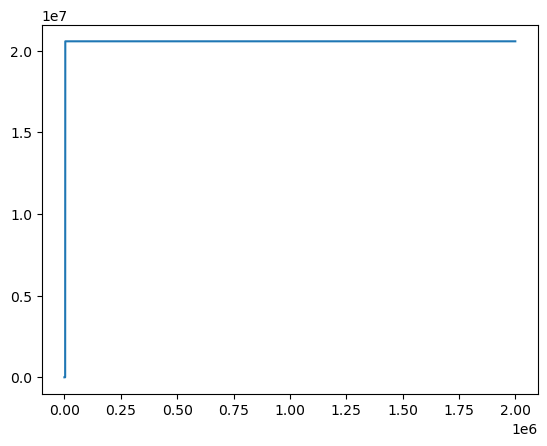

In [291]:
plt.plot(time_arr[::200], orthogonal_distance)

In [212]:

# Export trajectory in XYZ format (saving every 100th frame)
with open("trajectory.xyz", "w") as f:
    step_interval = 1000
    num_frames = steps // step_interval
    for t in range(num_frames):
        # Combine COM and surface positions for the frame.
        positions = np.empty((surface.shape[0] + 1, 3))
        positions[0] = headhist[t * step_interval]
        for j in range(surface.shape[0]):
            positions[j + 1] = surfacehist[t * step_interval, j]
        f.write(f"{positions.shape[0]}\n\n")
        for i in range(positions.shape[0]):
            f.write(f"C{i + 1} {positions[i, 0]:8.3f} {positions[i, 1]:8.3f} {positions[i, 2]:8.3f}\n")

In [ ]:
with open("trajectory.pdb", "w") as f:
    for t, positions in enumerate(np.concatenate(((np.reshape(headhist[::100],(2000,1,3))), surfacehist[::100]),axis=1)):  # Save every 100th frame
        f.write(f"MODEL     {t + 1}\n")
        f.write(f"ATOM  {1:5d}  C   UNK     1    {positions[0,0]:8.3f}{positions[0,1]:8.3f}{positions[0,2]:8.3f}  1.00  0.00           C\n")
        f.write(f"ATOM  {2:5d}  CA   UNK     1    {positions[1,0]:8.3f}{positions[1,1]:8.3f}{positions[1,2]:8.3f}  1.00  0.00           C\n")
        f.write(f"ATOM  {3:5d}  CB   UNK     1    {positions[2,0]:8.3f}{positions[2,1]:8.3f}{positions[2,2]:8.3f}  1.00  0.00           C\n")
        f.write(f"ATOM  {4:5d}  O   UNK     1    {positions[3,0]:8.3f}{positions[3,1]:8.3f}{positions[3,2]:8.3f}  1.00  0.00           O\n")
        f.write(f"ATOM  {5:5d}  N   UNK     1    {positions[4,0]:8.3f}{positions[4,1]:8.3f}{positions[4,2]:8.3f}  1.00  0.00           N\n")
        f.write("ENDMDL\n")

In [64]:
with open("polymerr.pdb", "w") as f:
    for i in range(polymerLength):
        f.write(f"ATOM  {2*i+1:5d}  C   UNK     1    {i:8.3f}{0:8.3f}{0:8.3f}  1.00  0.00           C\n")
        f.write(f"ATOM  {2*i+2:5d}  CA   UNK     1    {i:8.3f}{0.2:8.3f}{0:8.3f}  1.00  0.00           C\n")

In [328]:
with open("trajectory.xyz", "w") as f:
    for t, positions in enumerate(np.concatenate(((np.reshape(headhist[::1000],(2000,1,3))), surfacehist[::1000]),axis=1)):
        f.write(f"5 \n \n")
        f.write(f"C1 {positions[0,0]:8.3f}{positions[0,1]:8.3f}{positions[0,2]:8.3f} \n")
        f.write(f"C2 {positions[1,0]:8.3f}{positions[1,1]:8.3f}{positions[1,2]:8.3f} \n")
        f.write(f"C3 {positions[2,0]:8.3f}{positions[2,1]:8.3f}{positions[2,2]:8.3f} \n")
        f.write(f"C4 {positions[3,0]:8.3f}{positions[3,1]:8.3f}{positions[3,2]:8.3f} \n")
        f.write(f"C5 {positions[4,0]:8.3f}{positions[4,1]:8.3f}{positions[4,2]:8.3f} \n")

In [329]:
with open("polymerr.xyz", "w") as f:
    f.write(f"20 \n \n")
    for i in range(polymerLength):
        f.write(f"C{2*i+6} {i+1:8.3f}{0:8.3f}{0:8.3f} \n")
        f.write(f"C{2*i+7} {i+1:8.3f}{0.8:8.3f}{0:8.3f} \n")

In [230]:
np.empty_like(surface)

array([[5.1, 2.5, 0.6],
       [5. , 2.6, 0.6],
       [4.9, 2.5, 0.6],
       [5. , 2.4, 0.6]])

NameError: name 'harmonic_bond' is not defined